# 分类 Fashion-MNIST 数据集

现在轮到你来构建一个神经网络了。你将使用的是 [Fashion-MNIST 数据集](https://github.com/zalandoresearch/fashion-mnist)，这是 MNIST 数据集的替代品。对于神经网络而言，原始的 MNIST 数据集体量太小，因而你可以轻易达到 97% 以上的准确率。而 Fashion-MNIST 数据集是一组有关衣物的 28x28 灰阶图像。这个数据集比 MNIST 复杂得多，因此你能更好地判断神经网络的性能，它也更加接近你在现实世界中使用的数据集。

<img src='assets/fashion-mnist-sprite.png' width=500px>

在这个 notebook 中，你将构建专属于你的神经网络。在大多数情况下，你可以直接复制粘贴第三部分的代码，但这样一来你很难学到知识。因此我们推荐你自己编写代码来运行程序，这十分重要。不过在完成这个任务时，你也可以随时查阅和参考之前的 notebook。

首先，我们通过 torchvision 来加载数据集。

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

在这里，我们能看到其中一张图片。

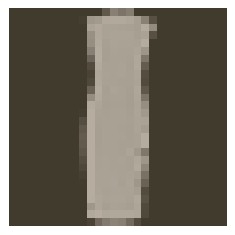

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

在加载数据之后，我们应该导入一些必要的包了。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

## 构建网络

在这里，你应该定义你的网络。如同 MNIST 数据集一样，这里的每张图片的像素为 28x28，共有 784 个像素点和 10 个类。你至少需要添加一个隐藏层。对于这些层，我们推荐你使用 ReLU 激活函数，并通过前向传播来返回 logits。层的数量和大小都由你来决定。

In [4]:
# TODO: Define your network architecture here
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

# 训练网络

现在，你应该构建你的网络并训练它了。首先，你需要定义[条件](http://pytorch.org/docs/master/nn.html#loss-functions)（比如 `nn.CrossEntropyLoss`）以及[优化器](http://pytorch.org/docs/master/optim.html)（比如 `optim.SGD` 或 `optim.Adam`）。

接着，你需要编写训练代码。请记住，训练传播是一个十分简明的过程：

* 在网络中进行前向传播来获取 logits 
* 使用 logits 来计算损失
* 使用 `loss.backward()` 在网络中进行后向传播来计算梯度
* 使用优化器执行一个学习步来更新权重

通过调整超参数（隐藏单元、学习速率等），你应该可以将训练损失控制在 0.4 以下。

In [5]:
# TODO: Create the network, define the criterion and optimizer
model = Network(784, 10, [500], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [6]:
# TODO: Train the network here
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    # Model in training mode, dropout is on
    model.train()
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            model.eval()
            
            accuracy = 0
            test_loss = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                # Set volatile to True so we don't save the history
                inputs = Variable(images, volatile=True)
                labels = Variable(labels, volatile=True)

                output = model.forward(inputs)
                test_loss += criterion(output, labels).data[0]
                
                ## Calculating the accuracy 
                # Model's output is log-softmax, take exponential to get the probabilities
                ps = torch.exp(output).data
                # Class with highest probability is our predicted class, compare with true label
                equality = (labels.data == ps.max(1)[1])
                # Accuracy is number of correct predictions divided by all predictions, just take the mean
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            model.train()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/2..  Training Loss: 63.437..  Test Loss: 7.448..  Test Accuracy: 0.389
Epoch: 1/2..  Training Loss: 6.521..  Test Loss: 4.192..  Test Accuracy: 0.376
Epoch: 1/2..  Training Loss: 9.879..  Test Loss: 5.797..  Test Accuracy: 0.350
Epoch: 1/2..  Training Loss: 6.241..  Test Loss: 3.085..  Test Accuracy: 0.309
Epoch: 1/2..  Training Loss: 2.675..  Test Loss: 2.569..  Test Accuracy: 0.300
Epoch: 1/2..  Training Loss: 4.374..  Test Loss: 3.758..  Test Accuracy: 0.292
Epoch: 1/2..  Training Loss: 6.290..  Test Loss: 4.763..  Test Accuracy: 0.265
Epoch: 1/2..  Training Loss: 3.760..  Test Loss: 3.651..  Test Accuracy: 0.260
Epoch: 1/2..  Training Loss: 4.604..  Test Loss: 9.175..  Test Accuracy: 0.236
Epoch: 1/2..  Training Loss: 3.339..  Test Loss: 3.201..  Test Accuracy: 0.176
Epoch: 1/2..  Training Loss: 3.192..  Test Loss: 3.272..  Test Accuracy: 0.183
Epoch: 1/2..  Training Loss: 3.539..  Test Loss: 2.835..  Test Accuracy: 0.207
Epoch: 1/2..  Training Loss: 2.744..  Test Loss: 2.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


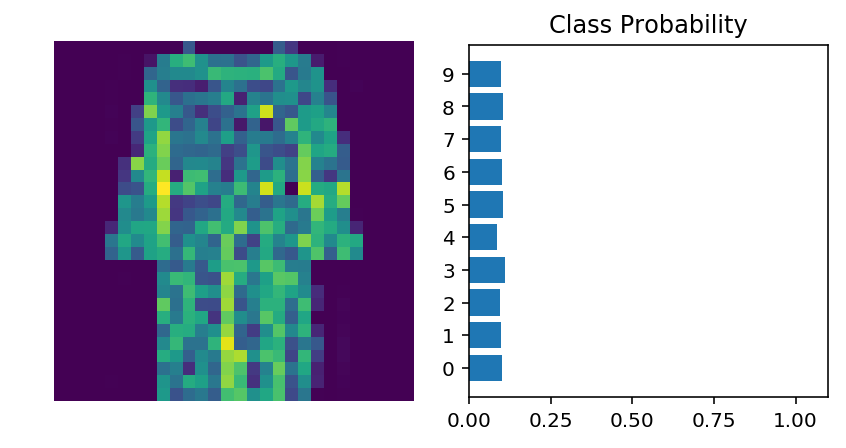

In [7]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
output = model.forward(Variable(img, volatile=True))
ps = torch.exp(output)
# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

训练好神经网络之后，你应该希望保存这个网络以便下次加载，而不是重新训练。很明显，每次使用时都重新训练网络并不现实。在实际操作中，你将会在训练网络之后将模型保存，接着重新加载网络以进行训练或是预测。在下一部分，我将为你展示如何保存和加载训练好的模型。